# Задание 3

In [ ]:
#!pip install -q catalyst

     |████████████████████████████████| 481kB 4.7MB/s 
     |████████████████████████████████| 163kB 23.0MB/s 
     |████████████████████████████████| 317kB 24.6MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 


In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [2]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features)) # YOUR CODE GOES HERE
        self.bias = bias
        if bias:
            self.bias_term = torch.zeros(out_features) # YOUR CODE GOES HERE
            #self.bias_term = nn.Parameter(torch.ones(out_features))# YOUR CODE GOES HERE (corrent, but answer is uncorrect???)

    def forward(self, x):
        x =  x @ self.weights # YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term # YOUR CODE GOES HERE
        return x

### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

In [4]:
# синий - 0
# жёлтый - 1
# X.shape = (10000, 2)
# y.shape = (10000, )
# X[:,0] = coord_axis_x
# X[:, 1] = coord_axis_y

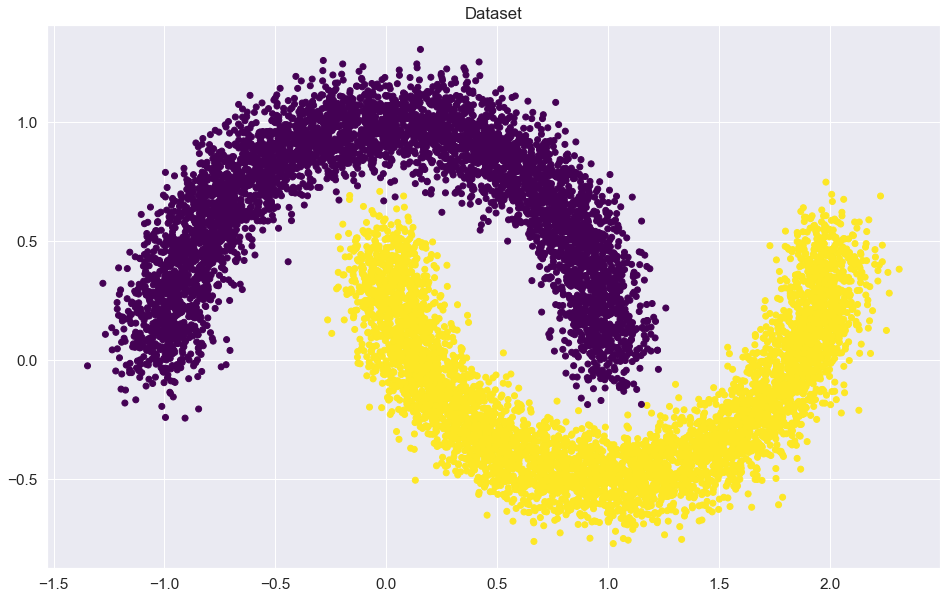

In [5]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [7]:
X_train_t =  torch.from_numpy(X_train).type(torch.float32)
y_train_t =  torch.from_numpy(y_train).type(torch.float32) 
X_val_t =  torch.from_numpy(X_val).type(torch.float32) 
y_val_t =  torch.from_numpy(y_val).type(torch.float32) 

Создаем `Dataset` и `DataLoader`. 

In [8]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [9]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

$$\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
    l_n = - w_n \left[ y_n \cdot \log \sigma(x_n)
    + (1 - y_n) \cdot \log (1 - \sigma(x_n)) \right]$$
    
,where x_n -- use as y_pred for n_row; w_n -- weight to n_row (optionally); y_n -- answer to this n_row row; finally get array n size, and in the end could do mean or other. Measures the Binary Cross Entropy between the target and the output (between two vectors)

In [10]:
linear_regression.weights

Parameter containing:
tensor([0.3367, 0.1288], requires_grad=True)

In [11]:
list(linear_regression.named_parameters())

[('weights',
  Parameter containing:
  tensor([0.3367, 0.1288], requires_grad=True))]

In [12]:
from torchsummary import summary

In [13]:
summary(linear_regression, batch_dim = (X_train.shape[1],))

Layer (type:depth-idx)                   Param #
└─LinearRegression: 0-1                  2
Total params: 2
Trainable params: 2
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
└─LinearRegression: 0-1                  2
Total params: 2
Trainable params: 2
Non-trainable params: 0

**Вопрос 1** Сколько обучаемых параметров у получившейся модели?

>**Ответ:** 3 

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [14]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    utils.set_global_seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch)  # YOUR CODE GOES HERE
        loss = loss_function(outp,y_batch) # # YOUR CODE GOES HERE
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)  # YOUR CODE GOES HERE
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.6484375
Iteration: 7500
Batch accuracy: 0.765625
Iteration: 15000
Batch accuracy: 0.8203125
Iteration: 22500
Batch accuracy: 0.8125
Iteration: 30000
Batch accuracy: 0.828125
Iteration: 37500
Batch accuracy: 0.828125
Iteration: 45000
Batch accuracy: 0.828125
Iteration: 52500
Batch accuracy: 0.828125
Iteration: 60000
Batch accuracy: 0.828125
Iteration: 67500
Batch accuracy: 0.828125
Iteration: 75000
Batch accuracy: 0.828125
Iteration: 82500
Batch accuracy: 0.8203125
Iteration: 90000
Batch accuracy: 0.828125

Iteration: 90047.Convergence. Stopping iterations.


**Вопрос 2**

Сколько итераций потребовалось, чтобы алгоритм сошелся?

>**Ответ:** 90047

### Визуализируем результаты

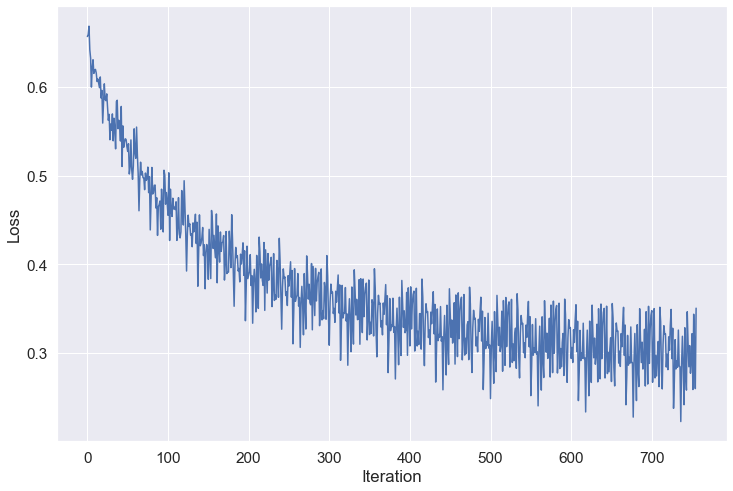

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

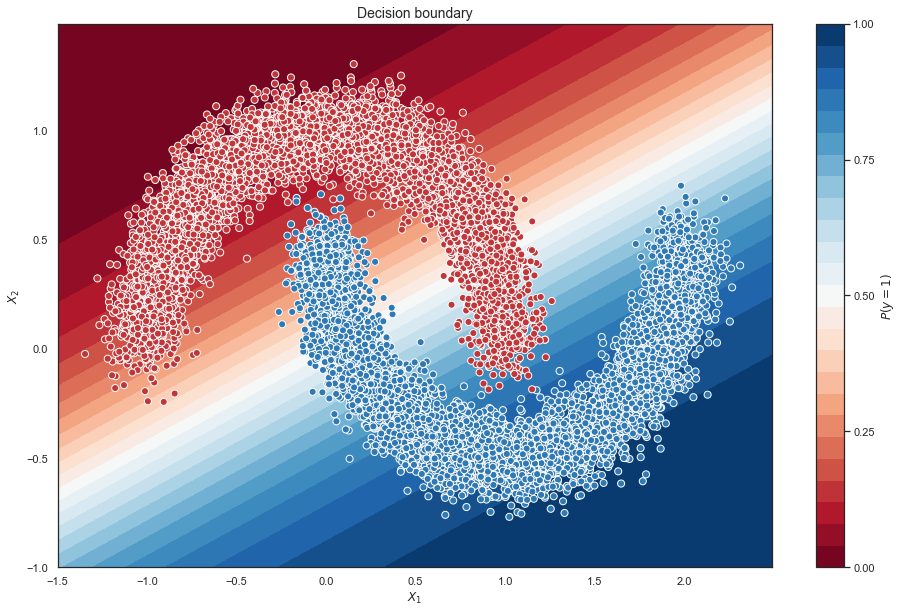

In [16]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [17]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [18]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val_t , predict(val_dataloader, linear_regression))

0.8688

In [19]:
predict(val_dataloader, linear_regression)

array([1., 1., 0., ..., 1., 0., 0.])

In [20]:
y_val_t

tensor([1., 1., 0.,  ..., 1., 0., 0.])

**Вопрос 3**

Какое `accuracy` получается после обучения?

>**Ответ:** 0.8688 

### MNIST

In [44]:
import os
from catalyst.contrib.datasets import MNIST

train_dataset = MNIST(root=os.getcwd(), train=True, download=True)
val_dataset = MNIST(root=os.getcwd(), train=False)
train_dataloader = DataLoader(train_dataset, batch_size = 128)# YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset, batch_size = 128) # YOUR CODE GOES HERE

In [45]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

In [46]:
#activation = nn.LeakyReLU

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [63]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [49]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train() # YOUR CODE GOES HERE
                optimizer.zero_grad() # YOUR CODE GOES HERE
                outp = model(x_batch.type(torch.float32).unsqueeze(1)) # YOUR CODE GOES HERE
                loss = criterion(outp, y_batch) # YOUR CODE GOES HERE
                loss.backward() # YOUR CODE GOES HERE
                optimizer.step() # YOUR CODE GOES HERE
            else:
                model.eval() # YOUR CODE GOES HERE
                with torch.no_grad(): # YOUR CODE GOES HERE
                    outp = model(x_batch.type(torch.float32).unsqueeze(1)) # YOUR CODE GOES HERE
            preds = outp.argmax(-1)
            correct = (preds.flatten() == y_batch).type(torch.float32).sum() # YOUR CODE GOES HERE
            all = preds.size(0) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            #if k == "train":
                #loss = # YOUR CODE GOES HERE
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9002666666666667
Loader: valid. Accuracy: 0.9061714285714285
Epoch: 2
Loader: train. Accuracy: 0.9562166666666667
Loader: valid. Accuracy: 0.9533714285714285
Epoch: 3
Loader: train. Accuracy: 0.96555
Loader: valid. Accuracy: 0.9621142857142857
Epoch: 4
Loader: train. Accuracy: 0.9695166666666667
Loader: valid. Accuracy: 0.9662285714285714
Epoch: 5
Loader: train. Accuracy: 0.9740333333333333
Loader: valid. Accuracy: 0.9687142857142857
Epoch: 6
Loader: train. Accuracy: 0.9747833333333333
Loader: valid. Accuracy: 0.9717142857142858
Epoch: 7
Loader: train. Accuracy: 0.9781833333333333
Loader: valid. Accuracy: 0.9758571428571429
Epoch: 8
Loader: train. Accuracy: 0.98015
Loader: valid. Accuracy: 0.9778142857142857
Epoch: 9
Loader: train. Accuracy: 0.9797166666666667
Loader: valid. Accuracy: 0.9774714285714285
Epoch: 10
Loader: train. Accuracy: 0.9811
Loader: valid. Accuracy: 0.9784142857142857


Попробуйте разные функции активации. Позапускайте ячейки сверху несколько раз изменив функции активации. После каждого обучения запустите одну из ячеек снизу. Таким образом мы получим график accuracy/epoch для каждой функции активации.

In [50]:
plain_accuracy = accuracy["valid"]

In [36]:
relu_accuracy = accuracy["valid"]

In [43]:
leaky_relu_accuracy = accuracy["valid"]

In [56]:
leaky_relu_accuracy == plain_accuracy # по-умолчанию leaky-relu

True

In [27]:
elu_accuracy = accuracy["valid"]

### Accuracy

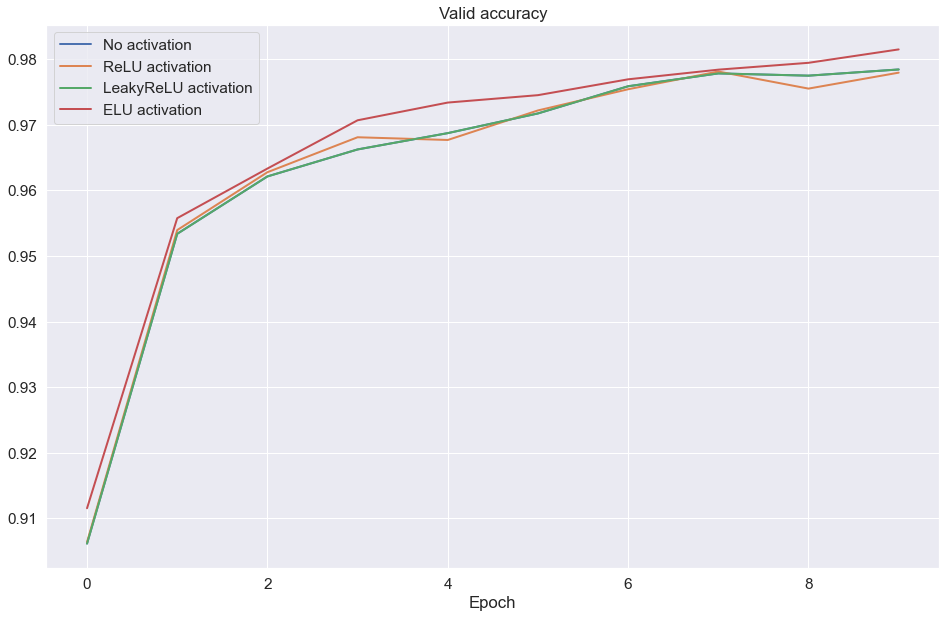

In [53]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

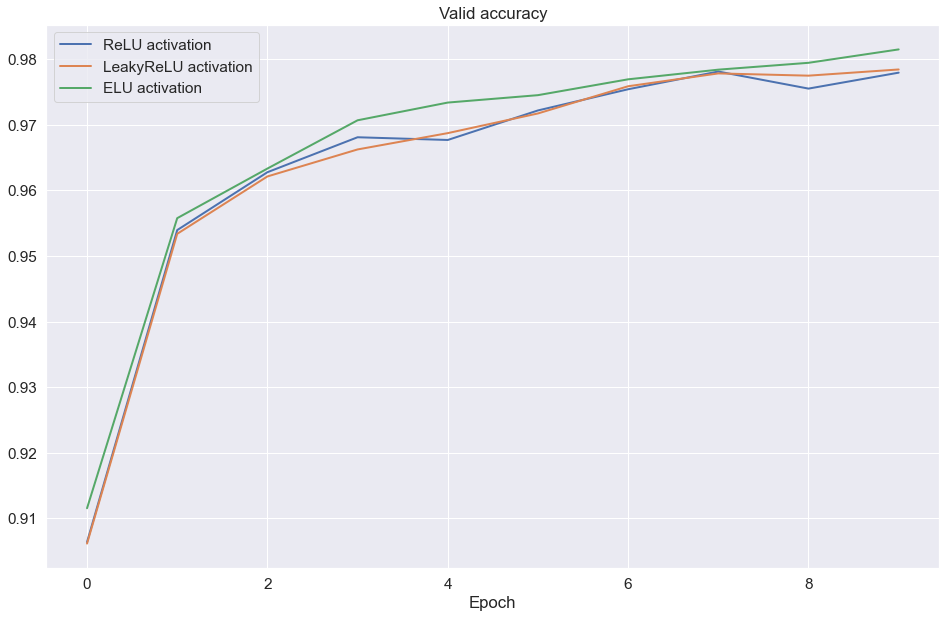

In [54]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4** Какая из активаций показала наивысший `accuracy`?

>**Ответ:** ReLu (но на самом деле ELU)

## Сверточные слои

### Ядра

In [46]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

"wget" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


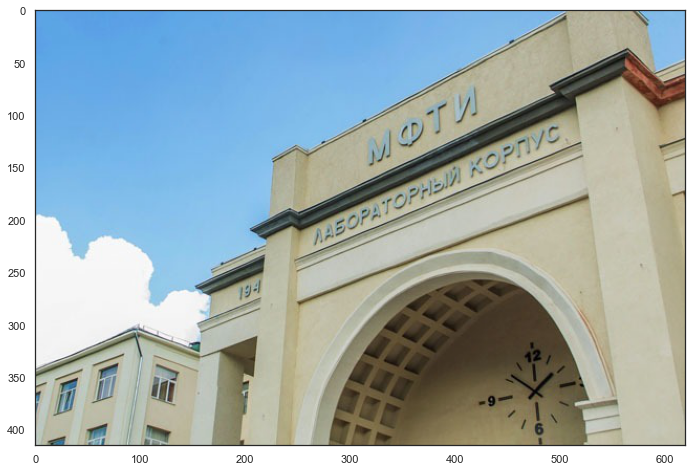

In [50]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],       3) Тождественное преобразование
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],    4) Выделение вертикальных границ  (на самом деле 5, так как после умножения оставляет середину(горизонт))
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],   5) Выделение горизонтальных границ(на самом деле 4, так как умножается на вертикальные столбцы(вертикаль))
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],      6) Выделение границ
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],     2) Увеличение резкости  
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],      1) Размытие  
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [77]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


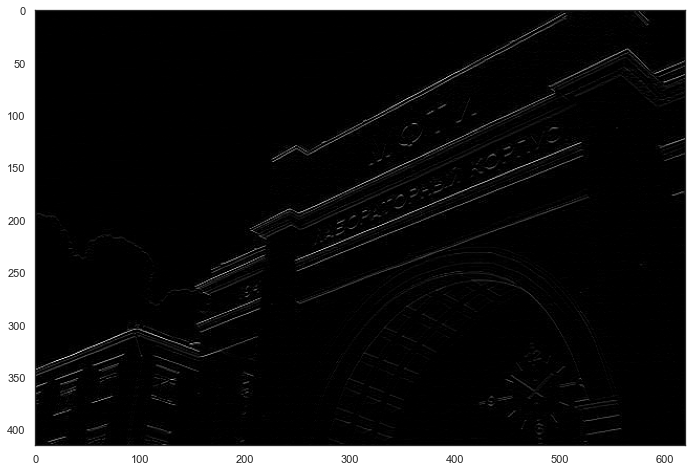

In [78]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5** Как вы считаете, как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие  

2) Увеличение резкости  

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

### LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Давайте посмотрим на архитектуру, предложенную еще в 1998 году!

In [59]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [60]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [64]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42+epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train() # YOUR CODE GOES HERE
                optimizer.zero_grad() # YOUR CODE GOES HERE
                outp = model(x_batch.type(torch.float32).unsqueeze(1).cuda()) # YOUR CODE GOES HERE
                loss = criterion(outp, y_batch.to(device)) # YOUR CODE GOES HERE
                loss.backward() # YOUR CODE GOES HERE
                optimizer.step() # YOUR CODE GOES HERE
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.type(torch.float32).unsqueeze(1).cuda())
            preds = outp.argmax(-1)
            correct = (preds.flatten().cpu() == y_batch).type(torch.float32).sum()  # YOUR CODE GOES HERE
            all =  preds.size(0) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            #if k == "train":
                #loss = # YOUR CODE GOES HERE
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.99345
Loader: valid. Accuracy: 0.9921
Epoch: 2
Loader: train. Accuracy: 0.99465
Loader: valid. Accuracy: 0.9932142857142857
Epoch: 3
Loader: train. Accuracy: 0.99525
Loader: valid. Accuracy: 0.9934857142857143
Epoch: 4
Loader: train. Accuracy: 0.9949666666666667
Loader: valid. Accuracy: 0.9928714285714285
Epoch: 5
Loader: train. Accuracy: 0.9955
Loader: valid. Accuracy: 0.9939857142857143
Epoch: 6
Loader: train. Accuracy: 0.9946166666666667
Loader: valid. Accuracy: 0.9929571428571429
Epoch: 7
Loader: train. Accuracy: 0.9959
Loader: valid. Accuracy: 0.9941
Epoch: 8
Loader: train. Accuracy: 0.9961666666666666
Loader: valid. Accuracy: 0.9946
Epoch: 9
Loader: train. Accuracy: 0.9963833333333333
Loader: valid. Accuracy: 0.995
Epoch: 10
Loader: train. Accuracy: 0.9971166666666667
Loader: valid. Accuracy: 0.9955714285714286


In [65]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

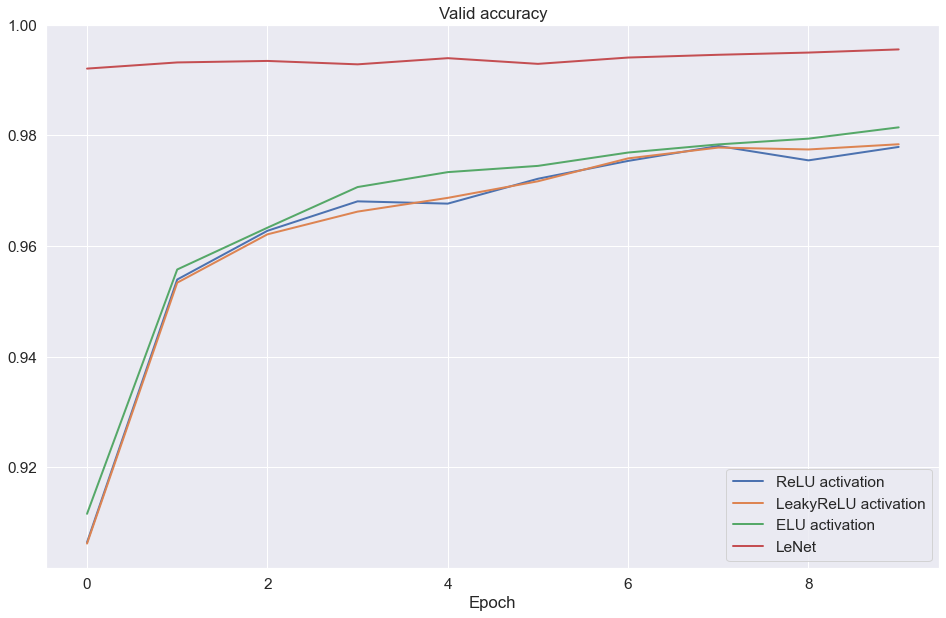

In [66]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

>**Ответ:** 0.99